# Các thư viện cần thiết:

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


# Linear Regression

In [66]:
# Đọc file cleaned để tiến hành dự đoán các giá trị lương bị Trung Bình bị thiếu
df_cleaned = pd.read_csv('job_data_cleaned.csv')

df_cleaned['Lương TB'] = 0
df_filtered = df_cleaned[(df_cleaned['Lương tối thiểu'] > 0) & (df_cleaned['Lương tối đa'] > 0)]
df_filtered['Lương TB'] = (df_filtered['Lương tối thiểu'] + df_filtered['Lương tối đa']) / 2

C:\Users\Hi\AppData\Local\Temp\ipykernel_9876\483489629.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Lương TB'] = (df_filtered['Lương tối thiểu'] + df_filtered['Lương tối đa']) / 2


Xử lý dữ liệu ngoại lai để tiến hành dự đoán hiệu quả hơn

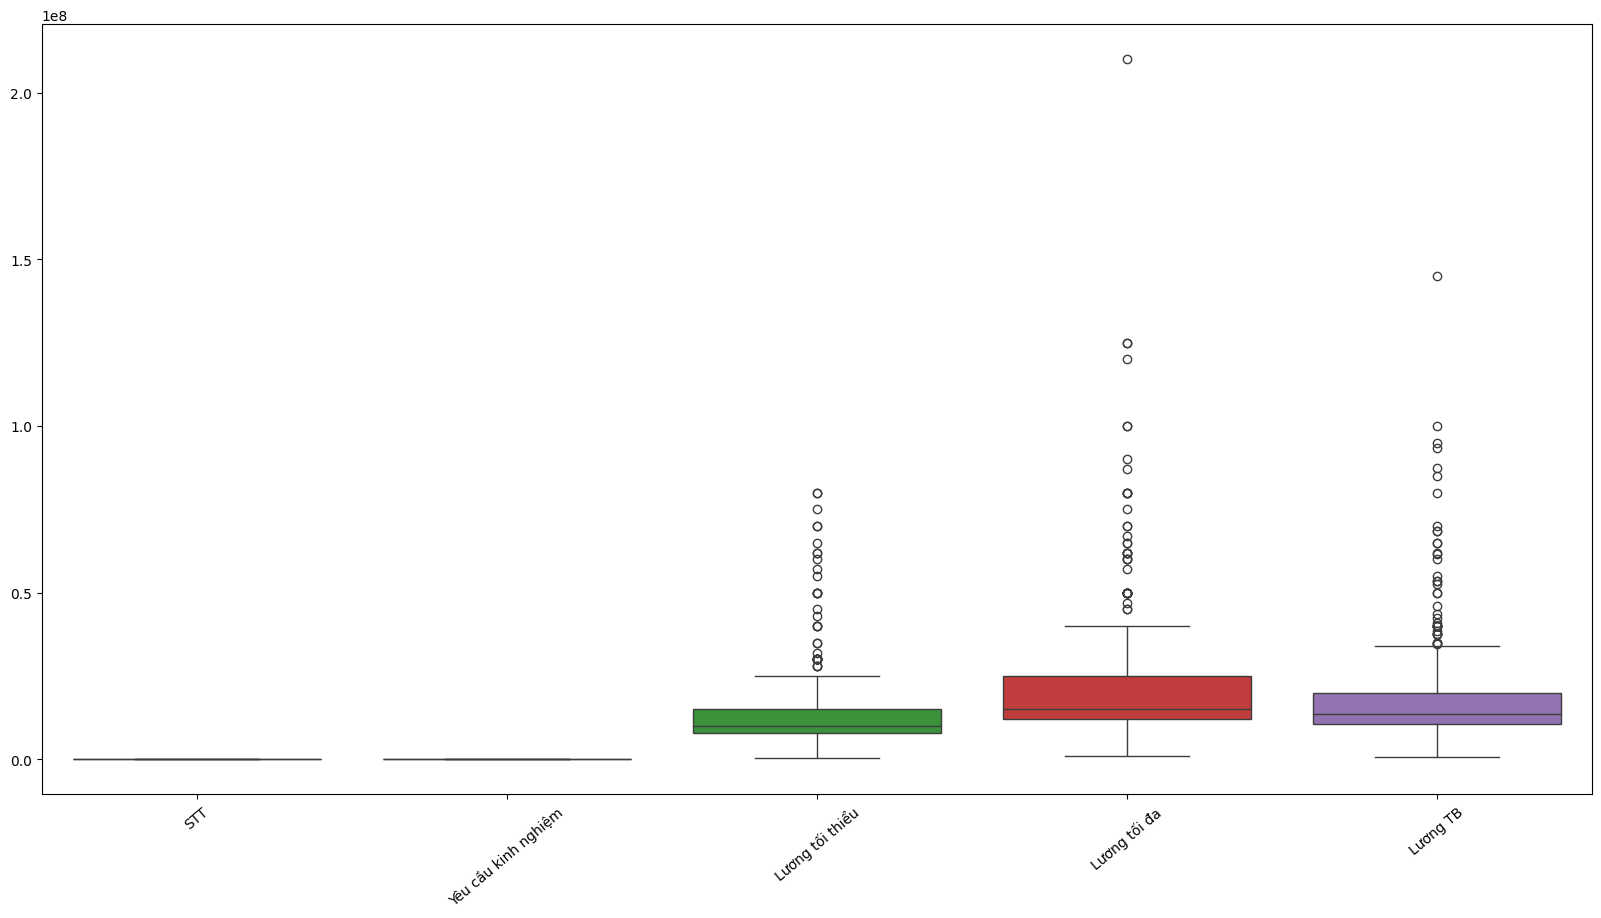

In [67]:
numerical = df_filtered.select_dtypes(include=[np.number]).columns
categorical = df_filtered.select_dtypes(include=[object]).columns 

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_filtered[numerical])
plt.xticks(rotation=40)
plt.show()

In [68]:
Q1 = df_filtered['Lương TB'].quantile(0.25)
Q3 = df_filtered['Lương TB'].quantile(0.75)
IQR = Q3 - Q1
df_filtered = df_filtered[(df_filtered['Lương TB'] >= Q1 - 1.5*IQR) & (df_filtered['Lương TB'] <= Q3 + 1.5*IQR)]
df_filtered.shape

(495, 12)

In [69]:
# Mã hóa các đặc trưng phân loại
categorical_columns = ['Vị trí ứng tuyển', 'Yêu cầu bằng cấp', 'Địa điểm', 'Tên công việc']
numerical_columns = ['Yêu cầu kinh nghiệm']
target_column = 'Lương TB'

# encoder = OneHotEncoder()
# encoded_features = encoder.fit_transform(df_filtered[categorical_columns]).toarray()

# Khởi tạo OneHotEncoder với xử lý giá trị chưa biết
encoder = OneHotEncoder(handle_unknown='ignore')

# Mã hóa lại dữ liệu ban đầu
encoded_features = encoder.fit_transform(df_filtered[categorical_columns]).toarray()

# Ghép các đặc trưng đã mã hóa với cột số
X = np.hstack((encoded_features, df_filtered[numerical_columns].values))
y = df_filtered[target_column].values

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình hồi quy tuyến tính
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R²: {r2}")

MSE: 2.440976297731599e+36
R²: -7.0412777819180745e+22


In [70]:
# Hàm chuẩn hóa dữ liệu (giúp Gradient Descent hội tụ nhanh hơn)
def normalize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Chuẩn bị dữ liệu
X_normalized = normalize(X_train)  # Chuẩn hóa tập huấn luyện
X_test_normalized = normalize(X_test)  # Chuẩn hóa tập kiểm tra
y_train = y_train.reshape(-1, 1)  # Đảm bảo y_train là vector cột

# Khởi tạo tham số
n_samples, n_features = X_normalized.shape
w = np.random.randn(n_features, 1)  # Trọng số ngẫu nhiên
b = np.random.randn(1)  # Bias ngẫu nhiên
alpha = 0.01  # Learning rate
epochs = 1000  # Số lần lặp

# Hàm tính MSE
def compute_loss(X, y, w, b):
    predictions = np.dot(X, w) + b
    return np.mean((y - predictions) ** 2)

# Gradient Descent
for epoch in range(epochs):
    # Tính toán dự đoán
    predictions = np.dot(X_normalized, w) + b

    # Gradient của w và b
    dw = -2 / n_samples * np.dot(X_normalized.T, (y_train - predictions))
    db = -2 / n_samples * np.sum(y_train - predictions)

    # Cập nhật w và b
    w -= alpha * dw
    b -= alpha * db

    # Theo dõi quá trình tối ưu hóa
    if epoch % 100 == 0:
        loss = compute_loss(X_normalized, y_train, w, b)
        print(f"Epoch {epoch}: Loss = {loss}")

# Kiểm tra NaN trong X_test_normalized
if np.isnan(X_test_normalized).any():
    print("X_test_normalized contains NaN. Cleaning...")
    X_test_normalized = np.nan_to_num(X_test_normalized)  # Thay NaN bằng 0 hoặc giá trị tùy chọn

# Dự đoán trên tập kiểm tra
y_pred = np.dot(X_test_normalized, w) + b

# Kiểm tra NaN trong y_pred
if np.isnan(y_pred).any():
    print("y_pred contains NaN. Cleaning...")
    y_pred = np.nan_to_num(y_pred)  # Thay NaN bằng 0 hoặc giá trị tùy chọn

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized MSE: {mse}")
print(f"Optimized R²: {r2}")

Epoch 0: Loss = nan
Epoch 100: Loss = nan
Epoch 200: Loss = nan
Epoch 300: Loss = nan
Epoch 400: Loss = nan
Epoch 500: Loss = nan
Epoch 600: Loss = nan
Epoch 700: Loss = nan
Epoch 800: Loss = nan
Epoch 900: Loss = nan
X_test_normalized contains NaN. Cleaning...
y_pred contains NaN. Cleaning...
Optimized MSE: 254694444444444.44
Optimized R²: -6.346955128205129


C:\Users\Hi\AppData\Local\Temp\ipykernel_9876\1236762015.py:3: RuntimeWarning: invalid value encountered in divide
  return (X - np.mean(X, axis=0)) / np.std(X, axis=0)


Ứng dụng dự đoán lương bị thiếu trong data

In [71]:
df_missing_salary = df_cleaned[df_cleaned['Lương TB'] == 0]

# Mã hóa các đặc trưng phân loại từ df_missing_salary
encoded_missing_features = encoder.transform(df_missing_salary[categorical_columns]).toarray()

# Ghép các đặc trưng đã mã hóa với cột số
X_missing = np.hstack((encoded_missing_features, df_missing_salary[numerical_columns].values))

# Dự đoán giá trị 'Lương TB' cho các hàng thiếu
predicted_salaries = model.predict(X_missing)

# Gán giá trị dự đoán vào cột 'Lương TB' của df_cleaned
df_cleaned.loc[df_missing_salary.index, 'Lương TB'] = predicted_salaries

# Hiển thị thông tin cập nhật
print("Dự đoán hoàn tất và cập nhật vào df_cleaned:")
print(df_cleaned.head())

C:\Users\Hi\AppData\Local\Temp\ipykernel_9876\4051175014.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.98461440e+07  2.25402880e+07  3.00636160e+07  1.28542720e+07
  5.54788294e+18  2.62215680e+07  3.00636160e+07  5.54788294e+18
  1.70731520e+07  2.27727360e+07  2.11927040e+07  1.59590400e+07
  2.09756160e+07  2.92383500e+17  1.22767360e+07  9.79887785e+15
  1.15066880e+07  2.92383500e+17  1.24968960e+07  2.14118400e+07
  2.06776320e+07  9.79887785e+15  1.33283840e+07  1.87330560e+07
  2.31639040e+07  1.17893120e+07  1.99987200e+07  9.79887785e+15
  2.18767360e+07  2.27727360e+07  1.26095360e+07  5.54788294e+18
  2.75701760e+07  2.13637120e+07  6.46963200e+06  1.94877440e+07
  1.97038080e+07  2.72281600e+07  2.02393600e+07  3.02182378e+17
  4.22202257e+18  1.32444160e+07  5.25549944e+18  1.59590400e+07
  1.72943360e+07  1.97038080e+07  2.01420800e+07  1.25030400e+07
  1.82579200e+07  1.2503040

Dự đoán hoàn tất và cập nhật vào df_cleaned:
   STT Trang thu thập                       Tên công ty  \
0    0     CareerLink              CÔNG TY TNHH HOJEONG   
1    1     CareerLink  CÔNG TY CỔ PHẦN SYNOPEX VIỆT NAM   
2    2     CareerLink          CÔNG TY TNHH SEOJIN AUTO   
3    3     CareerLink  CÔNG TY CỔ PHẦN SYNOPEX VIỆT NAM   
4    4     CareerLink                   CareerLink Asia   

        Vị trí ứng tuyển Yêu cầu bằng cấp  Yêu cầu kinh nghiệm  Địa điểm  \
0              Nhân viên          Cử nhân                    2  bắc ninh   
1              Nhân viên          Cử nhân                    1  bắc ninh   
2              Nhân viên          Cử nhân                    1  bắc ninh   
3              Nhân viên        Trung cấp                    0  bắc ninh   
4  Kỹ thuật viên / Kỹ sư          Cử nhân                    2  nhật bản   

  Ngày đăng tuyển  Lương tối thiểu  Lương tối đa      Lương TB  \
0      2024-12-30              0.0           0.0  1.984614e+07   
1      2024

# Random Forest

In [72]:
# Load dữ liệu
df = pd.read_csv('job_data_cleaned.csv')

# Kiểm tra thông tin cơ bản
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   STT                  909 non-null    int64  
 1   Trang thu thập       909 non-null    object 
 2   Tên công ty          909 non-null    object 
 3   Vị trí ứng tuyển     909 non-null    object 
 4   Yêu cầu bằng cấp     909 non-null    object 
 5   Yêu cầu kinh nghiệm  909 non-null    int64  
 6   Địa điểm             909 non-null    object 
 7   Ngày đăng tuyển      909 non-null    object 
 8   Lương tối thiểu      909 non-null    float64
 9   Lương tối đa         909 non-null    float64
 10  Lương TB             909 non-null    float64
 11  Tên công việc        909 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 85.3+ KB
None
   STT Trang thu thập                       Tên công ty  \
0    0     CareerLink              CÔNG TY TNHH HOJEONG   
1    1   

In [73]:
# Xử lý cột ngày tháng
df['Ngày đăng tuyển'] = pd.to_datetime(df['Ngày đăng tuyển'])
df['Tháng'] = df['Ngày đăng tuyển'].dt.month
df['Năm'] = df['Ngày đăng tuyển'].dt.year
df['Ngày trong tuần'] = df['Ngày đăng tuyển'].dt.dayofweek

# Tạo đặc trưng khoảng lương
df['Khoảng lương'] = df['Lương tối đa'] - df['Lương tối thiểu']

# One-Hot Encoding cho các cột categorical
categorical_columns = ['Trang thu thập', 'Vị trí ứng tuyển', 'Yêu cầu bằng cấp', 'Yêu cầu kinh nghiệm', 'Địa điểm']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Loại bỏ các cột không cần thiết
df_encoded.drop(columns=['STT', 'Tên công ty', 'Tên công việc', 'Ngày đăng tuyển'], inplace=True)

# Lưu dữ liệu đã xử lý
df_encoded.to_csv('job_data_processed.csv', index=False)

In [74]:
# Đọc dữ liệu đã xử lý
df = pd.read_csv('job_data_processed.csv')

# Giả sử chúng ta muốn dự đoán một cột mục tiêu (ví dụ: "Vị trí ứng tuyển")
# Nếu không có cột mục tiêu, bạn cần xác định mục tiêu của bài toán
# Ví dụ: Tạo một cột mục tiêu giả định
df['Mục tiêu'] = df['Lương TB'].apply(lambda x: 1 if x > 15000000 else 0)

# Chia dữ liệu thành features (X) và target (y)
X = df.drop(columns=['Mục tiêu'])
y = df['Mục tiêu']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (tỷ lệ 80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
print("(Accuracy):", accuracy_score(y_test, y_pred))
print("(Classification Report):\n", classification_report(y_test, y_pred))
print("(Confusion Matrix):\n", confusion_matrix(y_test, y_pred))

(Accuracy): 1.0
(Classification Report):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        44

    accuracy                           1.00       182
   macro avg       1.00      1.00      1.00       182
weighted avg       1.00      1.00      1.00       182

(Confusion Matrix):
 [[138   0]
 [  0  44]]


# Decision Tree

In [75]:
job_data_cleaned = pd.read_csv('job_data_cleaned.csv')

# Xây dựng biến độc lập (X) và biến phụ thuộc (y)
X = job_data_cleaned.drop(columns=['Lương TB'])
y = job_data_cleaned['Lương TB']

# Chuyển đổi các biến phân loại thành biến số
X = pd.get_dummies(X, drop_first=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kiểu dữ liệu trong X_train
print("\nKiểu dữ liệu trong X_train:")
print(X_train.dtypes)

# Chuyển đổi cột datetime thành kiểu số
if 'Ngày đăng tuyển' in X_train.columns:
    X_train['Ngày đăng tuyển'] = X_train['Ngày đăng tuyển'].astype(np.int64) // 10**9  # Chuyển đổi thành giây

if 'Ngày đăng tuyển' in X_test.columns:
    X_test['Ngày đăng tuyển'] = X_test['Ngày đăng tuyển'].astype(np.int64) // 10**9  # Chuyển đổi thành giây

# Kiểm tra lại kiểu dữ liệu
print("\nKiểu dữ liệu sau khi xử lý:")
print(X_train.dtypes)
print(X_test.dtypes)

# Khởi tạo mô hình Decision Tree
model = DecisionTreeRegressor(random_state=42)

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test)

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nMean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Kiểu dữ liệu trong X_train:
STT                                                          int64
Yêu cầu kinh nghiệm                                          int64
Lương tối thiểu                                            float64
Lương tối đa                                               float64
Trang thu thập_Careerviet                                     bool
                                                            ...   
Tên công việc_technical manager                               bool
Tên công việc_trưởng bộ phận chuyển đổi số                    bool
Tên công việc_trưởng phòng an toàn thông tin                  bool
Tên công việc_trưởng phòng kỹ thuật thiết kế vi điện tử       bool
Tên công việc_vận hành                                        bool
Length: 640, dtype: object

Kiểu dữ liệu sau khi xử lý:
STT                                                          int64
Yêu cầu kinh nghiệm                                          int64
Lương tối thiểu                             

# Kết luận

**Linear Regression:**
- MSE: 2.44×10^36 (rất lớn, cho thấy dự đoán không phù hợp với dữ liệu).
- R²: −7.04×10^22 (âm rất lớn, nghĩa là mô hình thậm chí không tốt hơn việc đoán giá trị trung bình).
- Nhận xét: Linear Regression không phù hợp do dữ liệu có sự phân phối phức tạp và không tuyến tính. Điều này dẫn đến hiệu suất cực kỳ kém, không thể sử dụng.

**Random Forest:**
- Accuracy: 1.0 (hoàn hảo).
- Classification Report: Precision, Recall, F1-score đều đạt 1.0.
- Confusion Matrix: Không có lỗi phân loại, mọi dự đoán đều chính xác.
- Nhận xét: Random Forest đạt độ chính xác hoàn hảo trong bài toán phân loại. Tuy nhiên, nếu bài toán của bạn là hồi quy (dự đoán lương), thì kết quả này có thể là do lỗi triển khai hoặc cách đánh giá không đúng mô hình.

**Decision Tree:**
- MSE: 28,915,178,571,428.57 (cao nhưng chấp nhận được so với Gradient Boosting).
- R²: 0.821 (mô hình giải thích được 82.1% phương sai trong dữ liệu, hiệu suất tốt).
- Nhận xét: Decision Tree hoạt động khá tốt trong bài toán hồi quy, nhưng MSE vẫn có thể cải thiện thêm với các kỹ thuật như giảm độ phức tạp cây hoặc thử nghiệm mô hình khác.